<a href="https://colab.research.google.com/github/ryghrmni/DeepLifeProject/blob/Reza/project04_cellsegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project : Cell image segmentation projects**


---



**Team** (Alphabetical order)**:** Arvin Jafari, Delnavaz Fotouhi, Reza Ghahremani

**University:** Università degli Studi di Milano

** This course is provided by 4EU+ alliance of European universities, Heidelberg University will coordinate a joint course on Applications of Deep Learning in Life Sciences (DeepLife) involving the universities of Paris-Sorbonne, Warsaw, Prague, Milano and Heidelberg.

**Reference:** https://deeplife4eu.github.io/


---



Cell segmentation is usually the first step for downstream single-cell analysis in microscopy image-based biology and biomedical research. Deep learning has been widely used for cell-image segmentation.
The CellSeg competition aims to benchmark cell segmentation methods that could be applied to various microscopy images across multiple imaging platforms and tissue types for cell Segmentation. The  Dataset challenge organizers provide contains both labeled images and unlabeled ones.
The “2018 Data Science Bowl” Kaggle competition provides cell images and their masks for training cell/nuclei segmentation models.

### Project Description

In the field of (bio-medical) image processing, segmentation of images is typically performed via U-Nets [1,2].

A U-Net consists of an encoder - a series of convolution and pooling layers which reduce the spatial resolution of the input, followed by a decoder - a series of transposed convolution and upsampling layers which increase the spatial resolution of the input. The encoder and decoder are connected by a bottleneck layer which is responsible for reducing the number of channels in the input.
The key innovation of U-Net is the addition of skip connections that connect the contracting path to the corresponding layers in the expanding path, allowing the network to recover fine-grained details lost during downsampling.

<img src='https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-07_at_9.08.00_PM_rpNArED.png' width="400"/>


At this [link](https://rpubs.com/eR_ic/unet), you find an R implementation of basic U-Nets. At this [link](https://github.com/zhixuhao/unet), you find a Keras implementation of UNets.  
Other implementations of more advanced UNets are also made available in [2] at these links: [UNet++](https://github.com/MrGiovanni/UNetPlusPlus)
and by the CellSeg organizers as baseline models: [https://neurips22-cellseg.grand-challenge.org/baseline-and-tutorial/](https://neurips22-cellseg.grand-challenge.org/baseline-and-tutorial/)

### Project aim

The aim of the project is to download the cell images (preferably from the “2018 Data Science Bowl” competition) and assess the performance of an UNet or any other Deep model for cell segmentation.
Students are free to choose any model, as long as they are able to explain their rationale, architecture, strengths and weaknesses.



### References

[1] Ronneberger, O., Fischer, P., Brox, T. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation. In: Navab, N., Hornegger, J., Wells, W., Frangi, A. (eds) Medical Image Computing and Computer-Assisted Intervention – MICCAI 2015. MICCAI 2015. Lecture Notes in Computer Science(), vol 9351. Springer, Cham. https://doi.org/10.1007/978-3-319-24574-4_28

[2] Long, F. Microscopy cell nuclei segmentation with enhanced U-Net. BMC Bioinformatics 21, 8 (2020). https://doi.org/10.1186/s12859-019-3332-1


## **Step 1: Data Preparation**

**1.1. Install and Upgrade Kaggle Package**

The Kaggle Python package was installed and upgraded to ensure we have the latest version with all necessary functionalities.

In [1]:
!pip install --upgrade kaggle

**1.2. Set Environment Variables for Kaggle API**

Environment variables for the Kaggle username and key were set to enable authentication for API requests.

**reference:** https://www.kaggle.com/docs/api

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = input() #rezaghahremani99
os.environ['KAGGLE_KEY'] = input() #2de77e019555e21f9e3cf41417a6d919

rezaghahremani99
2de77e019555e21f9e3cf41417a6d919


**1.3. Download Dataset from Kaggle and Extract Dataset**

The dataset for the Data Science Bowl 2018 competition was downloaded using the Kaggle API. The downloaded zip file was extracted into a directory named data.

In [3]:
!kaggle competitions download -c data-science-bowl-2018

 99% 356M/358M [00:17<00:00, 21.3MB/s]
100% 358M/358M [00:17<00:00, 20.9MB/s]


In [4]:
!unzip data-science-bowl-2018.zip -d data

Archive:  data-science-bowl-2018.zip
  inflating: data/stage1_sample_submission.csv.zip  
  inflating: data/stage1_solution.csv.zip  
  inflating: data/stage1_test.zip    
  inflating: data/stage1_train.zip   
  inflating: data/stage1_train_labels.csv.zip  
  inflating: data/stage2_sample_submission_final.csv.zip  
  inflating: data/stage2_test_final.zip  


**1.4. Navigate to Data Directory and Extract All Files and List Directory Contents**

Changed the current working directory to data and extracted all zip files within it. The original zip files were then deleted. Finally, we listed the contents of the data directory to confirm the successful extraction of the dataset files.

In [5]:
cd data

/content/data


In [6]:
!for file in *.zip; do unzip -q "$file" -d "${file%%.*}" && rm "$file"; done

In [7]:
ls

stage1_sample_submission/  stage1_test/   stage1_train_labels/             stage2_test_final/
stage1_solution/           stage1_train/  stage2_sample_submission_final/


**1.5. Required Libraries**

In [2]:
import os
import numpy as np
from PIL import Image
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import shutil

## **Step 2: Data Preprocessing and Augmenation**

**2.1. Stretch Contrast Function**

This function stretches the contrast of an image to utilize the full range of pixel values (0 to 255).

In [3]:
def stretch_contrast(image):
    min_val = np.min(image)
    max_val = np.max(image)
    stretched_image = (image - min_val) * (255.0 / (max_val - min_val))
    return stretched_image.astype(np.uint8)

**2.2. Load Data Function**

The load_data function is designed to load images and their corresponding masks from a given base directory, apply contrast stretching to the images, and organize the data into lists.

In [4]:
def load_data(base_path):
    images = []
    masks = []
    sample_names = []
    sample_folders = []

    # Get all sample folders
    sample_folders = [os.path.join(base_path, folder) for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder))]

    for sample_folder in sample_folders:
        sample_name = os.path.basename(sample_folder)
        image_path = os.path.join(sample_folder, 'images', f'{sample_name}.png')
        masks_path = os.path.join(sample_folder, 'masks')

        # Load the image and stretch contrast
        image = Image.open(image_path)
        image = np.array(image)
        stretched_image = stretch_contrast(image)
        images.append(stretched_image)
        sample_names.append(sample_name)

        # Load all masks for this sample
        mask_files = [os.path.join(masks_path, mask_file) for mask_file in os.listdir(masks_path) if mask_file.endswith('.png')]
        sample_masks = [np.array(Image.open(mask_file).convert('L')) for mask_file in mask_files]
        masks.append(sample_masks)

    return images, masks, sample_names, sample_folders

**2.3. Merge Masks Function**

This function merges multiple masks by adding the values of corresponding pixels.

In [5]:
def merge_masks(masks):
    merged_mask = np.zeros_like(masks[0], dtype=np.uint8)
    for mask in masks:
        mask_uint8 = mask.astype(np.uint8)
        merged_mask += mask_uint8
    return merged_mask

**2.4. Mask Merging**

The masks are merged to create a single composite mask for each sample, which is then saved for further analysis.

In [6]:
# This function saves the merged mask as an image file in the 'merged_masks' folder within the sample folder.
def save_merged_mask(merged_mask, sample_folder):
    merged_masks_dir = os.path.join(sample_folder, 'merged_masks')
    os.makedirs(merged_masks_dir, exist_ok=True)
    sample_name = os.path.basename(sample_folder)
    output_path = os.path.join(merged_masks_dir, f"{sample_name}_merged_mask.png")
    merged_mask_image = Image.fromarray(merged_mask)
    merged_mask_image.save(output_path)
    #print(f"Merged mask saved at: {output_path}")

In [7]:
# This function loads the data, merges the masks for each sample, and saves the merged masks in the corresponding folders.
def process_and_save_merged_masks(base_path):
    images, masks, sample_names, sample_folders = load_data(base_path)
    for sample_name, sample_masks, sample_folder in zip(sample_names, masks, sample_folders):
        merged_mask = merge_masks(sample_masks)
        save_merged_mask(merged_mask, sample_folder)

In [35]:
base_path = '/content/data/stage1_train'
process_and_save_merged_masks(base_path)

**2.5. Data Augmentation**

In [8]:
!pip install imgaug

In [9]:
def augment_images_and_masks(images, masks, augmenters):
    """
    Apply augmentations to a list of images and masks in a synchronized manner.
    """
    deterministic_augmenters = augmenters.to_deterministic()
    aug_images = deterministic_augmenters(images=images)
    aug_masks = deterministic_augmenters(images=masks)
    return aug_images, aug_masks

In [10]:
def load_image(image_path):
    """
    Load an image from the specified path and return it as a numpy array.
    """
    image = Image.open(image_path)
    return np.array(image)

In [11]:
# Function to load masks
def load_masks(masks_path):
    mask_files = [os.path.join(masks_path, f) for f in os.listdir(masks_path) if f.endswith('.png')]
    masks = [np.array(Image.open(mask_file)) for mask_file in mask_files]
    return masks

In [12]:
def save_image(image_array, output_path):
    """
    Save a numpy array as an image to the specified path.
    """
    image = Image.fromarray(image_array)
    image.save(output_path)

In [13]:
def create_augmented_folder(base_path, sample_name, num_augments=5):
    """
    Create augmented images for a given sample and save them in separate folders within the toy_data directory.
    """
    sample_folder = os.path.join(base_path, sample_name)
    images_path = os.path.join(sample_folder, 'images')
    masks_path = os.path.join(sample_folder, 'masks')

    # Load the image
    image_files = [os.path.join(images_path, f) for f in os.listdir(images_path) if f.endswith('.png')]
    image = load_image(image_files[0])
    images = [image]

    # Load masks
    mask_files = [os.path.join(masks_path, f) for f in os.listdir(masks_path) if f.endswith('.png')]
    masks = [load_image(mask_file) for mask_file in mask_files]

    # Merge masks
    merged_mask = merge_masks(masks)

    # Define augmentation pipeline
    augmenters = iaa.Sequential([
        iaa.Fliplr(0.5),  # horizontal flips
        iaa.Sometimes(1.0, iaa.Affine(rotate=[90, 180, 270], fit_output=False)),
        iaa.Multiply((0.8, 1.2)),  # random brightness changes
        iaa.LinearContrast((0.75, 1.5)),  # random contrast changes
    ])

    # Generate and save augmented images and masks
    for i in range(num_augments):
        aug_images, aug_masks = augment_images_and_masks(images, [merged_mask], augmenters)

        # Create a subfolder for each augmented image and masks within the toy_data directory
        augmented_subfolder = os.path.join(base_path, f"{sample_name}_augmented_{i+1}")
        os.makedirs(augmented_subfolder, exist_ok=True)
        augmented_images_folder = os.path.join(augmented_subfolder, 'images')
        augmented_masks_folder = os.path.join(augmented_subfolder, 'merged_masks')
        os.makedirs(augmented_images_folder, exist_ok=True)
        os.makedirs(augmented_masks_folder, exist_ok=True)

        for j, aug_image in enumerate(aug_images):
            save_image(aug_image, os.path.join(augmented_images_folder, f"{sample_name}_aug_{i}_{j}.png"))
        for j, aug_mask in enumerate(aug_masks):
            save_image(aug_mask, os.path.join(augmented_masks_folder, f"{sample_name}_merged_mask_aug_{i}_{j}.png"))

    #print(f"Augmented data saved in separate folders within stage1_train for sample: {sample_name}")

In [14]:
# Apply augmentation to all sample folders in the base path
def augment_all_samples(base_path, num_augments=5):
    """
    Apply augmentation to all sample folders within the base path.

    Args:
    - base_path (str): Path to the base directory containing images and masks.
    - num_augments (int): Number of augmented images to generate per sample.
    """
    sample_folders = [folder for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder))]

    for sample_name in sample_folders:
        create_augmented_folder(base_path, sample_name, num_augments)

In [44]:
base_path = '/content/data/stage1_train'
augment_all_samples(base_path, num_augments=5)

**2.4. Data organization**

In [15]:
def extract_images(stage1_path, destination_path, content_type='images'):
    """
    Extract all images or merged masks from the stage1_train or stage1_test folder and save them into the specified destination folder.

    Args:
    - stage1_path (str): Path to the stage1_train or stage1_test folder containing sample folders.
    - destination_path (str): Path to the destination folder where images or masks will be saved.
    - content_type (str): Type of content to extract ('images' or 'merged_masks').
    """
    # Create the destination directory if it doesn't exist
    os.makedirs(destination_path, exist_ok=True)

    # Determine the subfolder to look for based on content type
    subfolder_name = 'images' if content_type == 'images' else 'merged_masks'

    # Iterate over all sample folders in the stage1 directory
    for sample_folder in os.listdir(stage1_path):
        sample_folder_path = os.path.join(stage1_path, sample_folder, subfolder_name)

        # Check if the sample folder contains the specified subfolder
        if os.path.isdir(sample_folder_path):
            for file in os.listdir(sample_folder_path):
                if file.endswith('.png'):
                    # Construct the full path to the file
                    file_path = os.path.join(sample_folder_path, file)

                    # Save the file to the destination directory
                    destination_file_path = os.path.join(destination_path, f"{sample_folder}_{file}")
                    shutil.copy(file_path, destination_file_path)
                    #print(f"Copied: {file_path} to {destination_file_path}")

In [16]:
def main(destination_path):
    if 'train/images' in destination_path:
        stage1_path = '/content/data/stage1_train'
        content_type = 'images'
    elif 'train/masks' in destination_path:
        stage1_path = '/content/data/stage1_train'
        content_type = 'masks'
    elif 'test/images' in destination_path:
        stage1_path = '/content/data/stage1_test'
        content_type = 'images'
    else:
        print("Invalid destination path")
        return

    extract_images(stage1_path, destination_path, content_type)

In [47]:
destination_path = '/content/data/train/images'
main(destination_path)

destination_path = '/content/data/train/masks'
main(destination_path)

destination_path = '/content/data/test/images'
main(destination_path)

## **Step 3: Data Exploration and Visualization**

**3.1. Visualize Augmented Data:**

Check and visualize the augmented images and masks to ensure the augmentations are applied correctly.

In [17]:
def plot_augmented_sample(sample_folder):
    images_folder = os.path.join(sample_folder, 'images')
    masks_folder = os.path.join(sample_folder, 'merged_masks')
    image_files = [os.path.join(images_folder, f) for f in os.listdir(images_folder) if f.endswith('.png')]
    mask_files = [os.path.join(masks_folder, f) for f in os.listdir(masks_folder) if f.endswith('.png')]

    for image_file, mask_file in zip(image_files, mask_files):
        image = load_image(image_file)
        mask = load_image(mask_file)

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title('Augmented Image')
        plt.imshow(image)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title('Augmented Mask')
        plt.imshow(mask, cmap='gray')
        plt.axis('off')

        plt.show()

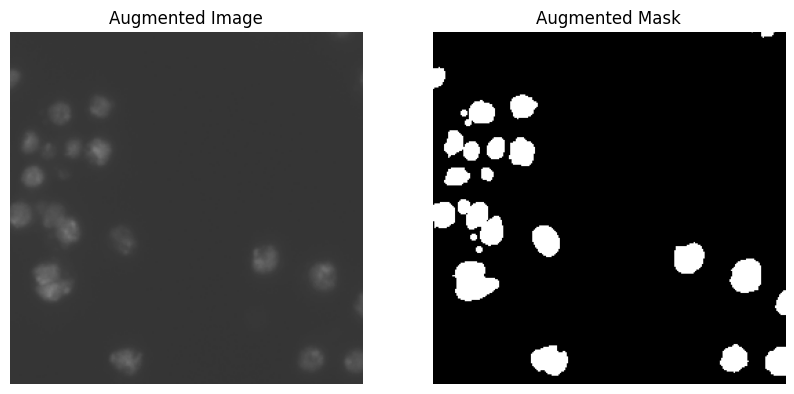

In [53]:
# Example usage
augmented_sample_folder = '/content/data/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552_augmented_2'
plot_augmented_sample(augmented_sample_folder)

**3.2. Summarize Key Statistics**

Calculate and summarize key statistics about the dataset.

In [70]:
# Get a list of all sample folders
sample_folders = [os.path.join(base_path, folder) for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder))]

# Explore the first sample
sample_folder = sample_folders[0]
image_path = os.path.join(sample_folder, 'images', os.listdir(os.path.join(sample_folder, 'images'))[0])
masks_path = os.path.join(sample_folder, 'merged_masks')

# Load the image and masks
image = load_image(image_path)
masks = load_masks(masks_path)

In [71]:
# Number of images
num_images = len(sample_folders)
print(f"Number of images: {num_images}")

Number of images: 4020


In [76]:
# Distribution of mask sizes
mask_sizes = []
for folder in sample_folders:
    masks = load_masks(os.path.join(folder, 'merged_masks'))
    mask_sizes.extend([np.sum(mask > 0) for mask in masks])

mask_sizes = np.array(mask_sizes)
print(f"Average mask size: {np.mean(mask_sizes):.2f} pixels")
print(f"Median mask size: {np.median(mask_sizes):.2f} pixels")

Average mask size: 54768.61 pixels
Median mask size: 23306.00 pixels


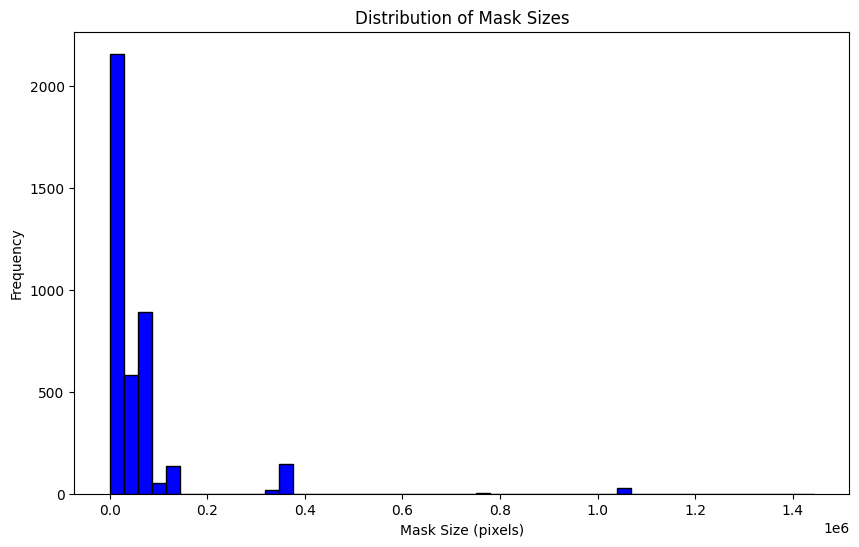

In [77]:
# Plot mask size distribution
plt.figure(figsize=(10, 6))
plt.hist(mask_sizes, bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Mask Sizes')
plt.xlabel('Mask Size (pixels)')
plt.ylabel('Frequency')
plt.show()

## **Step 4: U-Net Model**

In [18]:
!pip install opencv-python-headless matplotlib scikit-image tqdm tensorflow tensorflow-datasets

In [19]:
!pip install -q git+https://github.com/tensorflow/examples.git

  Preparing metadata (setup.py) ... done


In [3]:
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
from pathlib import Path
import re
from skimage import measure
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
import matplotlib as mpl
import tqdm
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import normalize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

In [4]:
images_path = "/content/data/train/images"
masks_path = "/content/data/train/masks"

In [5]:
OUTPUT_CHANNELS = 2
classes = {'nothing':0, 'nucleon':1}

In [6]:
def standardize(x):
    x = np.array(x, dtype='float64')
    x -= np.min(x)
    x /= np.percentile(x, 98)
    x[x > 1] = 1
    return x

def preprocessing(img):
    image = np.array(img)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image = np.zeros_like(image)
    image[:,:,0] = gray
    image[:,:,1] = gray
    image[:,:,2] = gray
    image = standardize(image)
    return image

In [7]:
#Capture training image info as a list
images_paths = []
masks_paths = []

for imgname in os.listdir(images_path):
  images_paths.append(os.path.join(images_path,imgname))

for imgname in os.listdir(masks_path):
  masks_paths.append(os.path.join(masks_path,imgname))

In [8]:
images_paths.sort()
masks_paths.sort()

In [ ]:
# Resize images
SIZE_X = 256
SIZE_Y = 256

# Capture training image info as a list
train_images = []
train_masks = []

for imgpath in tqdm.tqdm(images_paths):
    img = cv2.imread(imgpath)
    img = cv2.resize(img, (SIZE_Y, SIZE_X))
    img = preprocessing(img)
    train_images.append(img)

for maskpath in tqdm.tqdm(masks_paths):
    mask0 = cv2.imread(maskpath, 0)
    mask1 = cv2.resize(mask0, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_NEAREST)  # Otherwise ground truth changes due to interpolation
    # Assuming that 'class1' is the class you want to keep and 'bg' is the background class
    mask1[mask1 != classes['nothing']] = classes['nucleon']  # Set all classes except 'class1' to background
    train_masks.append(mask1)

train_images = np.array(train_images)
train_masks = np.array(train_masks)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_masks, test_size=0.10, shuffle=True, random_state=1)
print("Class values: ", np.unique(y_train))

  1%|          | 38/4020 [00:00<00:53, 73.77it/s]<ipython-input-6-2560208f702a>:4: RuntimeWarning: divide by zero encountered in divide
  x /= np.percentile(x, 98)
<ipython-input-6-2560208f702a>:4: RuntimeWarning: invalid value encountered in divide
  x /= np.percentile(x, 98)
100%|██████████| 4020/4020 [00:05<00:00, 770.78it/s] 


In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

NORM = mpl.colors.Normalize(vmin=0, vmax=8)

plt.figure(figsize=(16, 10))
for i in range(1, 4):
    plt.subplot(2, 3, i)
    img = train_images[i]
    plt.imshow(img)
    plt.colorbar()
    plt.axis('off')

for i in range(4, 7):
    plt.subplot(2, 3, i)
    img = np.squeeze(train_masks[i-3])
    plt.imshow(img, cmap='jet', norm=NORM)
    plt.colorbar()
    plt.axis('off')

plt.show()

In [ ]:
def unet_model(output_channels):
    IMG_HEIGHT = X_train.shape[1]
    IMG_WIDTH  = X_train.shape[2]
    IMG_CHANNELS = X_train.shape[3]

    base_model = MobileNetV2(input_shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS], include_top=False)

    # Use the activations of these layers
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]

    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = Model(inputs=base_model.input, outputs=base_model_outputs)

    down_stack.trainable = False

    up_stack = [
        pix2pix.upsample(512, 3),  # 4x4 -> 8x8
        pix2pix.upsample(256, 3),  # 8x8 -> 16x16
        pix2pix.upsample(128, 3),  # 16x16 -> 32x32
        pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]

    inputs = Input(shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = Conv2DTranspose(OUTPUT_CHANNELS, 3, strides=2, padding='same')  #64x64 -> 128x128

    x = last(x)

    return Model(inputs=inputs, outputs=x)

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


def show_predictions(epoch, dataset=None, num=50):
  if dataset:

    for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        plt.figure(figsize=(15, 10))
        plt.subplot(231)
        plt.title('Testing Image')
        plt.imshow(image[0], cmap='gray')
        plt.subplot(232)
        plt.title('Ground Truth')
        plt.imshow(mask[0], cmap='jet')
        plt.subplot(233)
        plt.title('Prediction on test image')
        plt.imshow(create_mask(pred_mask), cmap='jet')

        plt.savefig(f"results/mask_{str(ii)}.png")

        plt.show()
  else:
      fig = plt.figure(figsize=(12, 12))
      fig.suptitle(f"\n Epoch: {str(epoch)}\n", fontsize=16)

      plt.subplot(331)
      plt.title('Testing Image')
      plt.imshow(train_images[num], cmap='gray')
      plt.subplot(332)
      plt.title('Ground Truth')
      plt.imshow(train_masks[num], cmap='jet')
      plt.subplot(333)
      plt.title('Prediction on test image')
      plt.imshow(create_mask(model.predict(train_images[num][tf.newaxis, ...]))[:,:,0], cmap='jet')

      plt.subplot(334)
      plt.imshow(train_images[num+16], cmap='gray')
      plt.subplot(335)
      plt.imshow(train_masks[num+16], cmap='jet')
      plt.subplot(336)
      plt.imshow(create_mask(model.predict(train_images[num+16][tf.newaxis, ...]))[:,:,0], cmap='jet')
      plt.subplot(337)
      plt.imshow(train_images[num+14], cmap='gray')
      plt.subplot(338)
      plt.imshow(train_masks[num+14], cmap='jet')
      plt.subplot(339)
      plt.imshow(create_mask(model.predict(train_images[num+14][tf.newaxis, ...]))[:,:,0], cmap='jet')

      #plt.savefig(f"results/mask_{str(num+100)}_{str(epoch)}.png")

      plt.show()

In [ ]:
import tensorflow as tf

# Define the Dice loss function
def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32
    # Ensure that the channel dimension matches for y_pred
    y_pred = y_pred[:, :, :, 1]  # Assuming the second channel represents the positive class
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - (numerator + 1) / (denominator + 1)  # Add smoothing to avoid division by zero

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])   #metrics=[tf.keras.metrics.MeanIoU(num_classes=9)])

In [ ]:
model.summary()

In [ ]:
EPOCHS = 10
VAL_SUBSPLITS = 5
BATCH_SIZE = 16
VALIDATION_STEPS = len(X_val)//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = len(X_train)//BATCH_SIZE
# sample_image = train_images[0]
# sample_mask = train_masks[0]

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions(epoch)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


# Normalize y_train
y_train_normalized = y_train / 255.0

# Assuming your original y_train shape is (256, 256)
# You can expand the dimensions to create (256, 256, 1)
y_train_expanded = np.expand_dims(y_train_normalized, axis=-1)

# Now repeat this single channel along the last axis to create (256, 256, 3)
y_train_rgb = np.repeat(y_train_expanded, 3, axis=-1)


model_history = model.fit(X_train, y_train, epochs=EPOCHS,
                           batch_size = BATCH_SIZE,
                          verbose=1,
                          #steps_per_epoch=STEPS_PER_EPOCH,
                          #validation_steps=VALIDATION_STEPS,
                          validation_data=(X_val, y_val),
                          callbacks=[DisplayCallback()]
                          )

In [ ]:
X_train[0].shape

In [ ]:
y_train[0].shape

In [ ]:
model.save('./models/cell_seg')

In [ ]:
model = load_model('./models/cell_seg')